In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score, train_test_split

from patsy import dmatrices, dmatrix

from datetime import date, datetime

import mkl
import accelerate

pd.set_option('display.max_columns', None)


# Suppress annoying deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data import

In [2]:
train_data = pd.read_csv('train.csv')
train_data.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
test_data = pd.read_csv('test.csv')
test_ids = test_data.ID
test_data.head(5)

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


#### Extracting and cleaning labels

In [4]:
labels = train_data.OutcomeType

labels.head(5)

0    Return_to_owner
1         Euthanasia
2           Adoption
3           Transfer
4           Transfer
Name: OutcomeType, dtype: object

## Extracting and cleaning features
#### Going to use the trick where the train and test features are concatenated for cleaning purposes

In [5]:
feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color']

train_features = train_data.loc[:, feature_columns]
n_train_features = len(train_features.index)
print 'Train data count: {}'.format(n_train_features)

test_features = test_data.loc[:, feature_columns]
n_test_features = len(test_features.index)
print 'Test data count: {}'.format(n_test_features)

features = pd.concat((train_features, test_features), ignore_index=True)
print 'Total data count: {}'.format(len(features.index))

Train data count: 26729
Test data count: 11456
Total data count: 38185


#### Whether or not the animal has a name

In [6]:
features['HasName'] = features.Name.notnull().astype(float)
features.head(5)

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0


#### Sex and spay/neuter status

In [7]:
# Cleaning sex
# When sex is unknown, code "None" for both Sex and Fixed values. 
# This will get handled later when dummy-coding variables. The default
# will be the "unknown" case and there will be separate features for
# both male/female and fixed/intact (for a total of 4 dummy variables).
features.loc[(features.SexuponOutcome == 'Unknown'), 'SexuponOutcome'] = None
features['Sex'] = features.SexuponOutcome.str.split(' ').str[1]
features['IsFixed'] = features.SexuponOutcome.str.split(' ').str[0]
features.loc[(features.IsFixed.str.contains('Neutered|Spayed',na=False)), 'IsFixed'] = 'Fixed'

features.loc[(features.Sex.isnull()), 'Sex'] = 'Unknown'
features.loc[(features.IsFixed.isnull()), 'IsFixed'] = 'Unknown'
#features.drop('SexuponOutcome', axis=1, inplace=True)
features.head(10)

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Sex,IsFixed
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,Male,Fixed
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,Female,Fixed
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,Male,Fixed
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,Male,Intact
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,Male,Fixed
5,A677334,Elsa,2014-04-25 13:04:00,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,1,Female,Intact
6,A699218,Jimmy,2015-03-28 13:11:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,1,Male,Intact
7,A701489,NaN,2015-04-30 17:02:00,Cat,None,3 weeks,Domestic Shorthair Mix,Brown Tabby,0,Unknown,Unknown
8,A671784,Lucy,2014-02-04 17:17:00,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,1,Female,Fixed
9,A677747,NaN,2014-05-03 07:48:00,Dog,Spayed Female,1 year,Cairn Terrier,White,0,Female,Fixed


#### Age - convert to continuous # of years

In [8]:
# Cleaning age
# Unknown values left as NaN
# Otherwise, age is converted to years.  (Note precision loss as unit reported grows)
features['AgeNum'] = pd.to_numeric(features['AgeuponOutcome'].str.split(' ').str[0])
features['AgeUnit'] = features['AgeuponOutcome'].str.split(' ').str[1]
features.loc[(features.AgeUnit.str.contains('year', na=False)), 'Age'] = features.AgeNum / 1.0
features.loc[(features.AgeUnit.str.contains('month', na=False)), 'Age'] = features.AgeNum / 12.0
features.loc[(features.AgeUnit.str.contains('week', na=False)), 'Age'] = features.AgeNum / (365.25 / 7)
features.loc[(features.AgeUnit.str.contains('day', na=False)), 'Age'] = features.AgeNum / 365.25
# features.drop(['AgeuponOutcome', 'AgeNum', 'AgeUnit'], axis=1, inplace=True)
features.drop(['AgeNum', 'AgeUnit'], axis=1, inplace=True)

# Adding a column to flag when the real age is not known
features['AgeUnknown'] = features.AgeuponOutcome.isnull().astype(float)

# Filling NA ages with per-species mean, which should hopefully at least get us an unbiased fill-in value
cat_mean_age = features.loc[((features.AgeuponOutcome.notnull()) & (features.AnimalType == 'Cat')), 'Age'].mean()
print 'Filling NA ages for cats with mean age: {}'.format(cat_mean_age)
features.loc[((features.AgeuponOutcome.isnull()) & (features.AnimalType == 'Cat')), 'Age'] = cat_mean_age

dog_mean_age = features.loc[((features.AgeuponOutcome.notnull()) & (features.AnimalType == 'Dog')), 'Age'].mean()
print 'Filling NA ages for dogs with mean age: {}'.format(dog_mean_age)
features.loc[((features.AgeuponOutcome.isnull()) & (features.AnimalType == 'Dog')), 'Age'] = dog_mean_age

features['AgeSquared'] = features.Age * features.Age
features['LogAge'] = np.log(features.Age + 1)

print 'Minimum age: {}'.format(features.Age.min())
print 'Maximum age: {}'.format(features.Age.max())

## Rescaling age features
## Commented out 'cuz it doesn't seem to help much
# max_age = features.Age.max()
# features.Age = features.Age / max_age

# max_squared_age = features.AgeSquared.max()
# features.AgeSquared = features.AgeSquared / max_squared_age

# max_log_age = features.LogAge.max()
# features.LogAge = features.LogAge / max_log_age

features.head(2)

Filling NA ages for cats with mean age: 1.35603498774
Filling NA ages for dogs with mean age: 2.73844387021
Minimum age: 0.0
Maximum age: 22.0


,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Sex,IsFixed,Age,AgeUnknown,AgeSquared,LogAge
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,Male,Fixed,1,0,1,0.693147
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,Female,Fixed,1,0,1,0.693147


#### Breed

In [9]:
# Cleaning breed
# First just extracting whether it's a mix or not
features['IsMix'] = features.Breed.str.contains('Mix|/').astype(float)

features['CleanBreed'] = features.Breed.str.replace(' Mix', '')
features['BreedBits'] = features.CleanBreed.str.split('/')

features['Breed1'] = features.BreedBits.str[0]
features['Breed2'] = features.loc[features.Breed.str.contains('/')].BreedBits.str[1]

breed1_counts = features.groupby('Breed1').size()
breed2_counts = features.groupby('Breed2').size()

breed_counts = breed1_counts.add(breed2_counts, 'index', fill_value=0)

breed1_counts = features.groupby('Breed1').size()
breed2_counts = features.groupby('Breed2').size()

breed_counts = breed1_counts.add(breed2_counts, 'index', fill_value=0)

popular_breeds = breed_counts.loc[breed_counts >= 100]
popular_breeds = set(popular_breeds.index)

features['PopularBreed'] = features.Breed.map(lambda b: any(pb in b for pb in popular_breeds))


features.loc[(features.Breed2.isnull()), 'Breed2'] = 'None'
features.loc[(features.PopularBreed.isnull()), 'PopularBreed'] = False

features.head(2)

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Sex,IsFixed,Age,AgeUnknown,AgeSquared,LogAge,IsMix,CleanBreed,BreedBits,Breed1,Breed2,PopularBreed
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,Male,Fixed,1,0,1,0.693147,1,Shetland Sheepdog,[Shetland Sheepdog],Shetland Sheepdog,None,False
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,Female,Fixed,1,0,1,0.693147,1,Domestic Shorthair,[Domestic Shorthair],Domestic Shorthair,None,True


#### Date and time

In [10]:
# Leaving month and day as strings because I think they make more sense as categorical variables
# than ordinal ones. For example, is January really "less than" December? It comes after it.
# This will make the feature count larger since we have to do so much dummy coding, but it makes
# it possible to have the model pick up on spikes that might not be related to the day's number
# in any linear way - e.g., if there's a spike of activity at the beginning and end of each month.
# 
# One issue there, though, is that it becomes a poor proxy for time in relation to the end of the
# month, since months can be anywhere from 28-31 days long. I don't know that that will really 
# matter much, though, unless there is a hard spike on certain times. If I get bored I'll do
# some plotting to look into that.
# 
# Leaving year out of it because it'll create an extrapolation issue - we can't really use fixed
# effects from past years to apply to future years.
#
# For time, I'm just getting hour of the day. I'm not sure there's much sense to 
# having greater resolution than that

# First, parsing the date into a datetime object for easier manipulation
features['Date'] = features.DateTime.apply(
                            lambda s: datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))

features['Month'] = features.Date.apply(lambda d: d.strftime('%B'))   # 'January', 'Feburary', . . .
features['Day'] = features.Date.apply(lambda d: d.strftime('Day%d'))  # 'Day01', 'Day02', . . .
features['WeekDay'] = features.Date.apply(lambda d: d.strftime('%A')) # 'Sunday', 'Monday', . . .  
features['Hour'] = features.Date.apply(lambda d: d.strftime('Hour%H')) # 'Hour00', 'Hour01', . . . 

# features.drop(['DateTime'], axis=1, inplace=True)

features.head(2)

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Sex,IsFixed,Age,AgeUnknown,AgeSquared,LogAge,IsMix,CleanBreed,BreedBits,Breed1,Breed2,PopularBreed,Date,Month,Day,WeekDay,Hour
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,Male,Fixed,1,0,1,0.693147,1,Shetland Sheepdog,[Shetland Sheepdog],Shetland Sheepdog,None,False,2014-02-12 18:22:00,February,Day12,Wednesday,Hour18
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,Female,Fixed,1,0,1,0.693147,1,Domestic Shorthair,[Domestic Shorthair],Domestic Shorthair,None,True,2013-10-13 12:44:00,October,Day13,Sunday,Hour12


#### Color

In [11]:
# Pulling out separate features for merle/tick/tabby/brindle/point
features['IsMerle'] = features.Color.str.contains('Merle').astype(float)
features['IsTick'] = features.Color.str.contains('Tick').astype(float)
features['IsTabby'] = features.Color.str.contains('Tabby').astype(float)
features['IsBrindle'] = features.Color.str.contains('Brindle').astype(float)
features['IsPoint'] = features.Color.str.contains('Point').astype(float)
features['IsTiger'] = features.Color.str.contains('Tiger').astype(float)
# maybe add tortie and calico

# Then remove them
features['CleanColor'] = features.Color.str.replace(' (Merle|Tick|Tabby|Brindle|Point|Tiger)', '')
features['ColorBits'] = features.CleanColor.str.split('/')

# And split to get rest
features['Color1'] = features.ColorBits.str[0]
features['Color2'] = features.loc[features.Color.str.contains('/')].ColorBits.str[1]
features.loc[(features.Color2.isnull()), 'Color2'] = 'None'


#features.loc[features.Color.str.contains('/')].head(10)
features.head(5)

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Sex,IsFixed,Age,AgeUnknown,AgeSquared,LogAge,IsMix,CleanBreed,BreedBits,Breed1,Breed2,PopularBreed,Date,Month,Day,WeekDay,Hour,IsMerle,IsTick,IsTabby,IsBrindle,IsPoint,IsTiger,CleanColor,ColorBits,Color1,Color2
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,Male,Fixed,1.000000,0,1.000000,0.693147,1,Shetland Sheepdog,[Shetland Sheepdog],Shetland Sheepdog,None,False,2014-02-12 18:22:00,February,Day12,Wednesday,Hour18,0,0,0,0,0,0,Brown/White,"[Brown, White]",Brown,White
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,Female,Fixed,1.000000,0,1.000000,0.693147,1,Domestic Shorthair,[Domestic Shorthair],Domestic Shorthair,None,True,2013-10-13 12:44:00,October,Day13,Sunday,Hour12,0,0,1,0,0,0,Cream,[Cream],Cream,None
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,Male,Fixed,2.000000,0,4.000000,1.098612,1,Pit Bull,[Pit Bull],Pit Bull,None,True,2015-01-31 12:28:00,January,Day31,Saturday,Hour12,0,0,0,0,0,0,Blue/White,"[Blue, White]",Blue,White
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,Male,Intact,0.057495,0,0.003306,0.055903,1,Domestic Shorthair,[Domestic Shorthair],Domestic Shorthair,None,True,2014-07-11 19:09:00,July,Day11,Friday,Hour19,0,0,0,0,0,0,Blue Cream,[Blue Cream],Blue Cream,None
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,Male,Fixed,2.000000,0,4.000000,1.098612,1,Lhasa Apso/Miniature Poodle,"[Lhasa Apso, Miniature Poodle]",Lhasa Apso,Miniature Poodle,True,2013-11-15 12:52:00,November,Day15,Friday,Hour12,0,0,0,0,0,0,Tan,[Tan],Tan,None


## Creating interaction variables
##### I'm going to go overboard here

## Coding data (using patsy)

In [12]:
# Pretty complete - as of 4/20 this is the one I used for the Kaggle submission
data = dmatrix('AnimalType + HasName + Sex + IsFixed + Age + AgeUnknown + AgeSquared + LogAge ' +
               '+ IsMix + Month + WeekDay + PopularBreed ' +
               '+ IsMerle + IsTick + IsTabby + IsBrindle + IsPoint + IsTiger ' +
               '+ AnimalType:HasName + AnimalType:Sex + AnimalType:IsFixed + AnimalType:Age ' +
               '+ AnimalType:AgeSquared + AnimalType:LogAge + AnimalType:IsMix + AnimalType:Month ' +
               '+ AnimalType:WeekDay ' + # + AnimalType:PopularBreed ' +
               '+ Sex:IsFixed + Sex:IsMix ' +
               '+ Breed1 + Breed2 + Color1 + Color2',  
               features, return_type='dataframe', NA_action='raise')
 
# plus a bunch of other interactions
# data = dmatrix('AnimalType + HasName + Sex + IsFixed + Age + AgeUnknown + AgeSquared + LogAge ' +
#                '+ IsMix + Month + WeekDay + IsMerle + IsTick + IsTabby + IsBrindle ' +
#                '+ IsPoint + IsTiger ' +
#                '+ AnimalType:HasName + AnimalType:Sex + AnimalType:IsFixed + AnimalType:Age ' +
#                '+ AnimalType:AgeSquared + AnimalType:LogAge + AnimalType:IsMix ' + 
#                '+ AnimalType:Month + AnimalType:WeekDay ' +
#                '+ AnimalType:Sex:IsFixed + AnimalType:Sex:Age + AnimalType:Sex:IsMix ' +
#                '+ AnimalType:IsFixed:IsMix + AnimalType:Sex:IsFixed:IsMix ' +
#                '+ Sex:IsFixed + Sex:IsMix ' +
#                '+ IsFixed:IsMix ' +
#                '+ Breed1 + Breed2 + Color1 + Color2',  
#                features, return_type='dataframe', NA_action='raise')

# Without interactions
# data = dmatrix('AnimalType + HasName + Sex + IsFixed + Age + AgeUnknown + AgeSquared + LogAge ' +
#                '+ IsMix + Month + WeekDay + PopularBreed ' +
#                '+ IsMerle + IsTick + IsTabby + IsBrindle + IsPoint + IsTiger ' +
#                '+ Breed1 + Breed2 + Color1 + Color2',  
#                features, return_type='dataframe', NA_action='raise')



# Trying to merge breed and color features
# features['breed_code'] = features.Breed1
# breed1 = dmatrix('breed_code', features, NA_action='raise')
# features['breed_code'] = features.Breed2
# breed2 = dmatrix('breed_code', features, NA_action='raise')

# breed1 | breed2
#breed2.head(10)
data.head(10)

,Intercept,AnimalType[T.Dog],Sex[T.Male],Sex[T.Unknown],IsFixed[T.Intact],IsFixed[T.Unknown],Month[T.August],Month[T.December],Month[T.February],Month[T.January],Month[T.July],Month[T.June],Month[T.March],Month[T.May],Month[T.November],Month[T.October],Month[T.September],WeekDay[T.Monday],WeekDay[T.Saturday],WeekDay[T.Sunday],WeekDay[T.Thursday],WeekDay[T.Tuesday],WeekDay[T.Wednesday],PopularBreed[T.True],Breed1[T.Affenpinscher],Breed1[T.Afghan Hound],Breed1[T.Airedale Terrier],Breed1[T.Akita],Breed1[T.Alaskan Husky],Breed1[T.Alaskan Malamute],Breed1[T.American Bulldog],Breed1[T.American Eskimo],Breed1[T.American Foxhound],Breed1[T.American Pit Bull Terrier],Breed1[T.American Shorthair],Breed1[T.American Staffordshire Terrier],Breed1[T.American Wirehair],Breed1[T.Anatol Shepherd],Breed1[T.Angora],Breed1[T.Australian Cattle Dog],Breed1[T.Australian Kelpie],Breed1[T.Australian Shepherd],Breed1[T.Australian Terrier],Breed1[T.Balinese],Breed1[T.Basenji],Breed1[T.Basset Hound],Breed1[T.Beagle],Breed1[T.Bearded Collie],Breed1[T.Beauceron],Breed1[T.Bedlington Terr],Breed1[T.Belgian Malinois],Breed1[T.Belgian Sheepdog],Breed1[T.Belgian Tervuren],Breed1[T.Bengal],Breed1[T.Bernese Mountain Dog],Breed1[T.Bichon Frise],Breed1[T.Black],Breed1[T.Black Mouth Cur],Breed1[T.Bloodhound],Breed1[T.Blue Lacy],Breed1[T.Bluetick Hound],Breed1[T.Boerboel],Breed1[T.Bombay],Breed1[T.Border Collie],Breed1[T.Border Terrier],Breed1[T.Boston Terrier],Breed1[T.Boxer],Breed1[T.Boykin Span],Breed1[T.British Shorthair],Breed1[T.Brittany],Breed1[T.Bruss Griffon],Breed1[T.Bull Terrier],Breed1[T.Bull Terrier Miniature],Breed1[T.Bulldog],Breed1[T.Bullmastiff],Breed1[T.Burmese],Breed1[T.Cairn Terrier],Breed1[T.Canaan Dog],Breed1[T.Cane Corso],Breed1[T.Cardigan Welsh Corgi],Breed1[T.Carolina Dog],Breed1[T.Catahoula],Breed1[T.Cavalier Span],Breed1[T.Chartreux],Breed1[T.Chesa Bay Retr],Breed1[T.Chihuahua Longhair],Breed1[T.Chihuahua Shorthair],Breed1[T.Chinese Crested],Breed1[T.Chinese Sharpei],Breed1[T.Chow Chow],Breed1[T.Cocker Spaniel],Breed1[T.Collie Rough],Breed1[T.Collie Smooth],Breed1[T.Cornish Rex],Breed1[T.Coton De Tulear],Breed1[T.Cymric],Breed1[T.Dachshund],Breed1[T.Dachshund Longhair],Breed1[T.Dachshund Stan],Breed1[T.Dachshund Wirehair],Breed1[T.Dalmatian],Breed1[T.Dandie Dinmont],Breed1[T.Devon Rex],Breed1[T.Doberman Pinsch],Breed1[T.Dogo Argentino],Breed1[T.Dogue De Bordeaux],Breed1[T.Domestic Longhair],Breed1[T.Domestic Medium Hair],Breed1[T.Domestic Shorthair],Breed1[T.Dutch Shepherd],Breed1[T.Eng Toy Spaniel],Breed1[T.English Bulldog],Breed1[T.English Cocker Spaniel],Breed1[T.English Coonhound],Breed1[T.English Foxhound],Breed1[T.English Pointer],Breed1[T.English Setter],Breed1[T.English Shepherd],Breed1[T.English Springer Spaniel],Breed1[T.Entlebucher],Breed1[T.Exotic Shorthair],Breed1[T.Feist],Breed1[T.Field Spaniel],Breed1[T.Finnish Spitz],Breed1[T.Flat Coat Retriever],Breed1[T.French Bulldog],Breed1[T.German Pinscher],Breed1[T.German Shepherd],Breed1[T.German Shorthair Pointer],Breed1[T.German Wirehaired Pointer],Breed1[T.Glen Of Imaal],Breed1[T.Golden Retriever],Breed1[T.Gordon Setter],Breed1[T.Great Dane],Breed1[T.Great Pyrenees],Breed1[T.Greater Swiss Mountain Dog],Breed1[T.Greyhound],Breed1[T.Harrier],Breed1[T.Havana Brown],Breed1[T.Havanese],Breed1[T.Himalayan],Breed1[T.Hovawart],Breed1[T.Ibizan Hound],Breed1[T.Irish Setter],Breed1[T.Irish Terrier],Breed1[T.Irish Wolfhound],Breed1[T.Italian Greyhound],Breed1[T.Jack Russell Terrier],Breed1[T.Japanese Bobtail],Breed1[T.Japanese Chin],Breed1[T.Javanese],Breed1[T.Jindo],Breed1[T.Keeshond],Breed1[T.Kuvasz],Breed1[T.Labrador Retriever],Breed1[T.Landseer],Breed1[T.Leonberger],Breed1[T.Lhasa Apso],Breed1[T.Lowchen],Breed1[T.Maine Coon],Breed1[T.Maltese],Breed1[T.Manchester Terrier],Breed1[T.Manx],Breed1[T.Mastiff],Breed1[T.Mexican Hairless],Breed1[T.Miniature Pinscher],Breed1[T.Miniature Poodle],Breed1[T.Miniature Schnauzer],Breed1[T.Munchkin Longhair],Breed1[T.Munchkin Shorthair],Breed1[T.Neapolita

## Getting numeric features into a single df

In [13]:
# I've tried to keep it so that the dtype of all the columns we want to use
# for training is float64, so we can just grab those
numeric_features = data.loc[:, (data.dtypes == np.float64) | (data.dtypes == np.int64)]

#print data.dtypes

print 'Feature count: {}'.format(len(numeric_features.dtypes))
numeric_features.head(10)

Feature count: 516


,Intercept,AnimalType[T.Dog],Sex[T.Male],Sex[T.Unknown],IsFixed[T.Intact],IsFixed[T.Unknown],Month[T.August],Month[T.December],Month[T.February],Month[T.January],Month[T.July],Month[T.June],Month[T.March],Month[T.May],Month[T.November],Month[T.October],Month[T.September],WeekDay[T.Monday],WeekDay[T.Saturday],WeekDay[T.Sunday],WeekDay[T.Thursday],WeekDay[T.Tuesday],WeekDay[T.Wednesday],PopularBreed[T.True],Breed1[T.Affenpinscher],Breed1[T.Afghan Hound],Breed1[T.Airedale Terrier],Breed1[T.Akita],Breed1[T.Alaskan Husky],Breed1[T.Alaskan Malamute],Breed1[T.American Bulldog],Breed1[T.American Eskimo],Breed1[T.American Foxhound],Breed1[T.American Pit Bull Terrier],Breed1[T.American Shorthair],Breed1[T.American Staffordshire Terrier],Breed1[T.American Wirehair],Breed1[T.Anatol Shepherd],Breed1[T.Angora],Breed1[T.Australian Cattle Dog],Breed1[T.Australian Kelpie],Breed1[T.Australian Shepherd],Breed1[T.Australian Terrier],Breed1[T.Balinese],Breed1[T.Basenji],Breed1[T.Basset Hound],Breed1[T.Beagle],Breed1[T.Bearded Collie],Breed1[T.Beauceron],Breed1[T.Bedlington Terr],Breed1[T.Belgian Malinois],Breed1[T.Belgian Sheepdog],Breed1[T.Belgian Tervuren],Breed1[T.Bengal],Breed1[T.Bernese Mountain Dog],Breed1[T.Bichon Frise],Breed1[T.Black],Breed1[T.Black Mouth Cur],Breed1[T.Bloodhound],Breed1[T.Blue Lacy],Breed1[T.Bluetick Hound],Breed1[T.Boerboel],Breed1[T.Bombay],Breed1[T.Border Collie],Breed1[T.Border Terrier],Breed1[T.Boston Terrier],Breed1[T.Boxer],Breed1[T.Boykin Span],Breed1[T.British Shorthair],Breed1[T.Brittany],Breed1[T.Bruss Griffon],Breed1[T.Bull Terrier],Breed1[T.Bull Terrier Miniature],Breed1[T.Bulldog],Breed1[T.Bullmastiff],Breed1[T.Burmese],Breed1[T.Cairn Terrier],Breed1[T.Canaan Dog],Breed1[T.Cane Corso],Breed1[T.Cardigan Welsh Corgi],Breed1[T.Carolina Dog],Breed1[T.Catahoula],Breed1[T.Cavalier Span],Breed1[T.Chartreux],Breed1[T.Chesa Bay Retr],Breed1[T.Chihuahua Longhair],Breed1[T.Chihuahua Shorthair],Breed1[T.Chinese Crested],Breed1[T.Chinese Sharpei],Breed1[T.Chow Chow],Breed1[T.Cocker Spaniel],Breed1[T.Collie Rough],Breed1[T.Collie Smooth],Breed1[T.Cornish Rex],Breed1[T.Coton De Tulear],Breed1[T.Cymric],Breed1[T.Dachshund],Breed1[T.Dachshund Longhair],Breed1[T.Dachshund Stan],Breed1[T.Dachshund Wirehair],Breed1[T.Dalmatian],Breed1[T.Dandie Dinmont],Breed1[T.Devon Rex],Breed1[T.Doberman Pinsch],Breed1[T.Dogo Argentino],Breed1[T.Dogue De Bordeaux],Breed1[T.Domestic Longhair],Breed1[T.Domestic Medium Hair],Breed1[T.Domestic Shorthair],Breed1[T.Dutch Shepherd],Breed1[T.Eng Toy Spaniel],Breed1[T.English Bulldog],Breed1[T.English Cocker Spaniel],Breed1[T.English Coonhound],Breed1[T.English Foxhound],Breed1[T.English Pointer],Breed1[T.English Setter],Breed1[T.English Shepherd],Breed1[T.English Springer Spaniel],Breed1[T.Entlebucher],Breed1[T.Exotic Shorthair],Breed1[T.Feist],Breed1[T.Field Spaniel],Breed1[T.Finnish Spitz],Breed1[T.Flat Coat Retriever],Breed1[T.French Bulldog],Breed1[T.German Pinscher],Breed1[T.German Shepherd],Breed1[T.German Shorthair Pointer],Breed1[T.German Wirehaired Pointer],Breed1[T.Glen Of Imaal],Breed1[T.Golden Retriever],Breed1[T.Gordon Setter],Breed1[T.Great Dane],Breed1[T.Great Pyrenees],Breed1[T.Greater Swiss Mountain Dog],Breed1[T.Greyhound],Breed1[T.Harrier],Breed1[T.Havana Brown],Breed1[T.Havanese],Breed1[T.Himalayan],Breed1[T.Hovawart],Breed1[T.Ibizan Hound],Breed1[T.Irish Setter],Breed1[T.Irish Terrier],Breed1[T.Irish Wolfhound],Breed1[T.Italian Greyhound],Breed1[T.Jack Russell Terrier],Breed1[T.Japanese Bobtail],Breed1[T.Japanese Chin],Breed1[T.Javanese],Breed1[T.Jindo],Breed1[T.Keeshond],Breed1[T.Kuvasz],Breed1[T.Labrador Retriever],Breed1[T.Landseer],Breed1[T.Leonberger],Breed1[T.Lhasa Apso],Breed1[T.Lowchen],Breed1[T.Maine Coon],Breed1[T.Maltese],Breed1[T.Manchester Terrier],Breed1[T.Manx],Breed1[T.Mastiff],Breed1[T.Mexican Hairless],Breed1[T.Miniature Pinscher],Breed1[T.Miniature Poodle],Breed1[T.Miniature Schnauzer],Breed1[T.Munchkin Longhair],Breed1[T.Munchkin Shorthair],Breed1[T.Neapolita

## Splitting train data and test data back out again

In [14]:
train_data = numeric_features[:n_train_features]
n_train_data = len(train_data.index)

test_data = numeric_features[n_train_features:]
n_test_data = len(test_data.index)

print '# train rows is {} (should be {})'.format(n_train_data, n_train_features)
print '# test rows is {} (should be {})'.format(n_test_data, n_test_features)

# train rows is 26729 (should be 26729)
# test rows is 11456 (should be 11456)


### And then splitting train data into train and test sets

In [15]:
# Using 80-20 split

train_set, test_set, train_labels, test_labels = \
    train_test_split(train_data, labels, test_size=0.2)
    
print train_set.shape
print test_set.shape
print train_labels.shape
print test_labels.shape

(21383, 516)
(5346, 516)
(21383,)
(5346,)


# Learning!!!

In [16]:
# Setting up some shared training params
cs = [.05, .1, .5, 1, 5, 10, 50]

# Function to print results
def print_gridsearch_results(model):
    print "Best score: {}".format(model.best_score_)
    print "Best parameters: {}".format(model.best_params_)
    print "\nAll parameters:"
    for element in model.grid_scores_:
        print"\t{}".format(element)
        
def draw_cm(classifier, data, labels):
    results = classifier.predict(data)

    label_names = np.sort(labels.unique())

    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    cm = confusion_matrix(labels, results)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)
    
def draw_rf_importances(clf, n_features = 50):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)

    indices = np.argsort(importances)[::-1]

    print 'Top features: '
    print train_data.columns.values[indices[:n_features]]

    # We have some many features let's 
    # just look at the first n_features
    plt.figure(figsize=(10,10))
    plt.title("Feature importances, first %d" % n_features)
    plt.bar(range(n_features),
            importances[indices][:n_features],
            color="g",
            yerr=std[indices][:n_features],
            align="center")

    plt.xticks(range(n_features), indices, rotation=70)

    plt.xlim([-1, n_features])
    plt.xlabel('Feature Indices')
    plt.grid()
    plt.show()
    
def draw_gb_importances(clf, n_features = 50):
    importances = clf.feature_importances_

    indices = np.argsort(importances)[::-1]

    print 'Top features: '
    print train_data.columns.values[indices[:n_features]]

    # We have some many features let's 
    # just look at the first n_features
    plt.figure(figsize=(10,10))
    plt.title("Feature importances, first %d" % n_features)
    plt.bar(range(n_features),
            importances[indices][:n_features],
            color="g",
            align="center")

    plt.xticks(range(n_features), indices, rotation=70)

    plt.xlim([-1, n_features])
    plt.xlabel('Feature Indices')
    plt.grid()
    plt.show()

## With logistic regression

CPU times: user 1min 11s, sys: 906 ms, total: 1min 12s
Wall time: 1min 24s
Score: 0.859224050742
Confusion matrix, without normalization
[[1841    0    1  207  147]
 [   4    0    0    5   32]
 [  41    0   21   74  172]
 [ 389    0    5  404  139]
 [ 438    0    3  162 1261]]


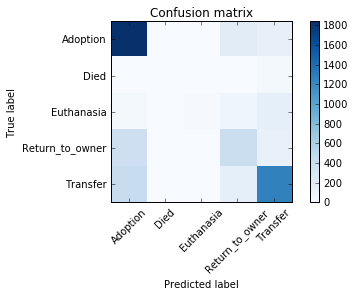

In [21]:
# From previous explorations, it seemed like L1 loss always works best, so I'm just sticking with that
params = { 
    'C': cs 
}

# clf = GridSearchCV(LogisticRegression(tol=.001, penalty='l1'), params, n_jobs = 2, scoring='log_loss')
# lr = clf.fit(train_set, train_labels)
lr = LogisticRegression(penalty='l1', C = .5)
%time lr.fit(train_set, train_labels)

scores = log_loss(test_labels, lr.predict_proba(test_set))
print 'Score: {}'.format(scores.mean())

#print_gridsearch_results(lr)
draw_cm(lr, test_set, test_labels)

In [ ]:
### 514 features (full model) Kaggle score:  0.85263
# clf_lr = LogisticRegression(C=.5, penalty='l1')

# clf_lr.fit(train_data, labels)

# print clf_lr.coef_

# draw_cm(clf_lr, train_data, labels)

## Random Forests

CPU times: user 2min 37s, sys: 5.25 s, total: 2min 42s
Wall time: 1min 5s
Score: 0.839741604669
Confusion matrix, without normalization
[[1795    0    1  249  151]
 [   6    2    1    5   27]
 [  38    0   29   82  159]
 [ 387    0    5  437  108]
 [ 409    0   16  189 1250]]


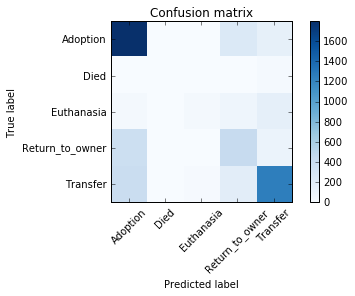

In [18]:
#target: .8278 @ d=24, n=2000

# target2: .8570 @ d=24
clf_rf = RandomForestClassifier(n_estimators=1000, n_jobs=4, max_depth=25)

%time clf_rf.fit(train_set, train_labels)
scores = log_loss(test_labels, clf_rf.predict_proba(test_set))
print 'Score: {}'.format(scores.mean())
draw_cm(clf_rf, test_set, test_labels)

CPU times: user 3min 27s, sys: 8.62 s, total: 3min 35s
Wall time: 1min 33s
Score: 0.470413668946
Confusion matrix, without normalization
[[10520     0     0   186    63]
 [   16   119     2     6    54]
 [  137     0  1008   175   235]
 [  880     0     0  3815    91]
 [ 1161     0     0   345  7916]]


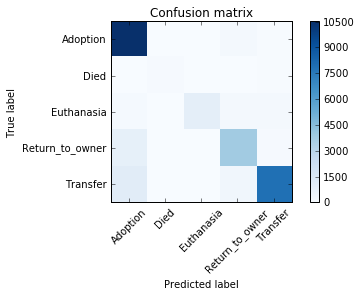

In [19]:
clf_rf_kag = RandomForestClassifier(n_estimators=1000, n_jobs=4, max_depth=24)

%time clf_rf_kag.fit(train_data, labels)
scores = log_loss(labels, clf_rf_kag.predict_proba(train_data))
print 'Score: {}'.format(scores.mean())
draw_cm(clf_rf_kag, train_data, labels)

Top features: 
['IsFixed[T.Intact]' 'Age' 'AgeSquared' 'LogAge' 'HasName'
 'AnimalType[T.Dog]:Age' 'Sex[T.Male]:IsFixed[T.Intact]'
 'AnimalType[T.Dog]:LogAge' 'AnimalType[T.Dog]:AgeSquared'
 'AnimalType[T.Dog]:IsFixed[T.Intact]' 'AnimalType[T.Dog]:HasName'
 'Color2[T.None]' 'Color2[T.White]' 'WeekDay[T.Saturday]' 'Color1[T.Black]'
 'Color1[T.Brown]' 'WeekDay[T.Sunday]' 'Sex[T.Male]:IsMix' 'Sex[T.Male]'
 'IsFixed[T.Unknown]' 'Breed1[T.Domestic Shorthair]' 'WeekDay[T.Tuesday]'
 'AnimalType[T.Dog]:IsMix' 'Sex[T.Unknown]' 'WeekDay[T.Monday]'
 'WeekDay[T.Wednesday]' 'WeekDay[T.Thursday]'
 'AnimalType[T.Dog]:PopularBreed[T.True]'
 'Sex[T.Unknown]:IsFixed[T.Unknown]' 'Month[T.October]' 'Color1[T.White]'
 'Sex[T.Unknown]:IsMix' 'Month[T.December]' 'Color1[T.Blue]'
 'Month[T.November]' 'AnimalType[T.Dog]:Sex[T.Male]' 'Breed1[T.Pit Bull]'
 'AnimalType[T.Dog]' 'Month[T.July]' 'Month[T.June]' 'IsTabby'
 'Month[T.May]' 'Month[T.January]' 'Breed2[T.None]' 'Month[T.August]'
 'Month[T.September]' 'Bre

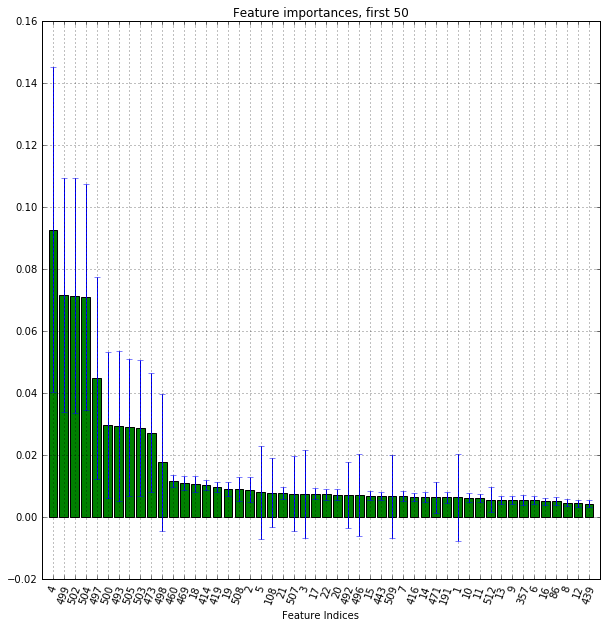

In [20]:
draw_rf_importances(clf_rf_kag)

## Gradient Boosting

In [ ]:
# .8352 @ n = 100, md = 4, mf = None

params = {
    'n_estimators': [10, 100, 300, 500],
    'max_depth': [1, 3, 5, 7, 9]
}
# clf = GridSearchCV(LogisticRegression(tol=.001, penalty='l1'), params, n_jobs = 2, scoring='log_loss')

# %time clf = GridSearchCV(GradientBoostingClassifier(max_features='auto'), params, n_jobs=4, scoring='log_loss')
# clf_gb = clf.fit(train_data, labels)



#clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=4, max_features='auto')

#%time clf_gb.fit(train_set, train_labels)
print_gridsearch_results(clf_gb)
scores = log_loss(test_labels, clf_gb.predict_proba(test_set))
print 'Score: {}'.format(scores.mean())
draw_cm(clf_gb, test_set, test_labels)

In [ ]:
clf_gb = GradientBoostingClassifier(n_estimators = 100, max_depth = 5)
%time clf.fit(train_set, train_labels)

scores = log_loss(test_labels, clf_gb.predict_proba(test_set))
print 'Score: {}'.format(scores.mean())
draw_cm(clf_gb, test_set, test_labels)
draw_gb_importances(clf_gb)

## Getting submission together

In [ ]:
predictions = clf_rf_kag.predict_proba(test_data)
label_names = np.sort(labels.unique())

results = pd.DataFrame(predictions, columns=label_names)
results.insert(0, 'ID', test_ids)

results.head(5)

In [ ]:
results.to_csv('kaggle_submission.csv', index=False)